In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation
import trimesh

plt.style.use('seaborn-v0_8-dark')
np.__version__

'1.26.4'

### 1. EulerAngles and Rotation Matrix

Following the ZYX convention, 

$$
\begin{align}
R &= R_{z}(\theta_{1}) \cdot R_{y}(\theta_{2}) \cdot R_{x}(\theta_{3}) \\
\implies R &= \begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) & 0 \\
\sin(\theta_1) & \cos(\theta_1) & 0 \\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
\cos(\theta_2) & 0 & \sin(\theta_2) \\
0 & 1 & 0 \\
-\sin(\theta_2) & 0 & \cos(\theta_2)
\end{bmatrix}

\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\theta_3) & -\sin(\theta_3) \\
0 & \sin(\theta_3) & \cos(\theta_3) \\
\end{bmatrix}


\end{align}
$$


In [2]:
def getR(theta, axis):
    if axis == 'x':
        return np.array([[1, 0, 0],
                        [0, np.cos(theta), -np.sin(theta)],
                        [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        return np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'z':
        return np.array([[np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1]])    
    

def euler2R(theta):
    return getR(theta[0], 'z') @ getR(theta[1], 'y') @ getR(theta[2], 'x')

euler2R([np.pi/2, 0, -np.pi/3])

array([[ 6.12323400e-17, -5.00000000e-01, -8.66025404e-01],
       [ 1.00000000e+00,  3.06161700e-17,  5.30287619e-17],
       [ 0.00000000e+00, -8.66025404e-01,  5.00000000e-01]])


The final rotation matrix for ZYX convention is given by, 
$$
\begin{align}
R = \begin{bmatrix}
\cos(\theta_1)\cos(\theta_2) & -\cos(\theta_1)\sin(\theta_3) + \sin(\theta_1)\sin(\theta_2)\cos(\theta_3) & \cos(\theta_1)\sin(\theta_2)\sin(\theta_3) + \sin(\theta_1)\cos(\theta_3) \\
\sin(\theta_1)\cos(\theta_2) & -\sin(\theta_1)\sin(\theta_3) - \cos(\theta_1)\sin(\theta_2)\cos(\theta_3) & \sin(\theta_1)\sin(\theta_2)\sin(\theta_3) - \cos(\theta_1)\cos(\theta_3) \\
-\sin(\theta_2) & \cos(\theta_2)\sin(\theta_3) & \cos(\theta_2)\cos(\theta_3)
\end{bmatrix}
\end{align}
$$

Therefore, upong solving we get, 

$$
\begin{align}
\theta_{1} &= \arctan2(R_{[1, 0]}, R_{[0, 0]}) \\
\theta_{2} &= -\arcsin(R_{[2,1]}) \\
\theta_{3} &= \arctan2(R_{[2, 1]}, R_{[2, 2]}) \\
\end{align}
$$

In [3]:
def R2euler(R):
    if np.abs(R[2, 0]) != 1:
        theta2 = -np.arcsin(R[2, 0])
        cos_theta2 = np.cos(theta2)
        theta1 = np.arctan2(R[2, 1] / cos_theta2, R[2, 2] / cos_theta2)  
        theta3 = np.arctan2(R[1, 0] / cos_theta2, R[0, 0] / cos_theta2)  
    else:
        # where there is a gimbal lock
        theta2 = np.pi / 2 if R[2, 0] == -1 else -np.pi / 2
        theta1 = np.arctan2(-R[0, 1], R[1, 1])
        theta3 = 0 

    return theta1, theta2, theta3

R2euler(euler2R([np.pi/2, 0, -np.pi/3])) == (-np.pi/3, 0, np.pi/2)

True

In [4]:
rot = np.array([[0, 0, 1],
                [0, 1, 0],
                [-1, 0, 0]])

R2euler(rot) == (0, np.pi/2, 0)
    

True

Text(0.5, 0, 'Z')

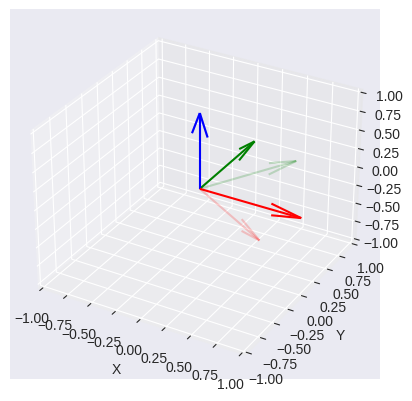

In [5]:
rot = euler2R([-np.pi/6, 0, 0])

space_frame = np.eye(3)

body_frame = rot @ space_frame

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(0, 0, 0, space_frame[0, 0], space_frame[1, 0], space_frame[2, 0], color='r')
ax.quiver(0, 0, 0, space_frame[0, 1], space_frame[1, 1], space_frame[2, 1], color='g')
ax.quiver(0, 0, 0, space_frame[0, 2], space_frame[1, 2], space_frame[2, 2], color='b')

ax.quiver(0, 0, 0, body_frame[0, 0], body_frame[1, 0], body_frame[2, 0], color='r', alpha=0.2)
ax.quiver(0, 0, 0, body_frame[0, 1], body_frame[1, 1], body_frame[2, 1], color='g', alpha=0.2)
ax.quiver(0, 0, 0, body_frame[0, 2], body_frame[1, 2], body_frame[2, 2], color='b', alpha=0.2)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

### 2. 3R manipulator EEF position

In [6]:

class Manipulator:
    def __init__(self, l1=1, l2=0.5, l3=0.25):
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        
        self.x1_init = np.array([self.l1, 0, 0])
        self.x2_init = np.array([self.l2, 0, 0])
        self.x3_init = np.array([self.l3, 0, 0])
        
        self.theta1 = self.theta2 = self.theta3 = 0

    def forward_kinematics(self, theta1, theta2, theta3):
        self.theta1 = np.deg2rad(theta1)
        self.theta2 = np.deg2rad(theta2)
        self.theta3 = np.deg2rad(theta3)
        R01 = euler2R([self.theta1, 0, 0]) 
        R12 = euler2R([self.theta2 + self.theta1, 0, 0])
        R23 = euler2R([self.theta3 + self.theta2 + self.theta1, 0, 0])
        
        self.x1 = R01 @ (self.x1_init)
        self.x2 = (R12 @ self.x2_init) + self.x1
        self.x3 = (R23 @ self.x3_init) + self.x2
        
    def inverse_kinematics(self, x, y, phi=np.pi/3):
        a = x - 0 * self.l3 * np.cos(phi)
        b = y - 0 * self.l3 * np.sin(phi)
        
        r = np.sqrt(x ** 2 + y ** 2)
        elbow_up, elbow_down = {}, {}
        
        print((r ** 2 - self.l1 ** 2 - self.l2 ** 2), (2 * self.l1 * self.l2))
        elbow_up['theta2'] = np.arccos((r ** 2 - self.l1 ** 2 - self.l2 ** 2) / (2 * self.l1 * self.l2))
        elbow_up['theta1'] = np.arctan2(b, a) - np.arctan2(self.l2 * np.sin(elbow_up['theta2']), self.l1 + self.l2 * np.cos(elbow_up['theta2']))
        elbow_up['theta3'] = 0 # phi - elbow_up['theta1'] - elbow_up['theta2']
        
        elbow_down['theta2'] = -elbow_up['theta2']
        elbow_down['theta1'] = np.arctan2(b, a) - np.arctan2(self.l2 * np.sin(elbow_down['theta2']), self.l1 + self.l2 * np.cos(elbow_down['theta2']))
        elbow_down['theta3'] = 0 # phi - elbow_down['theta1'] - elbow_down['theta2']
        
        for key in elbow_up.keys():
            elbow_up[key] = np.rad2deg(elbow_up[key])
            elbow_down[key] = np.rad2deg(elbow_down[key])
        
        return elbow_up, elbow_down
        
    def visualize(self, alpha=1.0):
        plt.plot([0, self.x1[0]], [0, self.x1[1]], 'r-', marker='o', alpha=alpha)
        plt.plot([self.x1[0], self.x2[0]], [self.x1[1], self.x2[1]], 'g-', marker='o', alpha=alpha)
        plt.plot([self.x2[0], self.x3[0]], [self.x2[1], self.x3[1]], 'b-', alpha=alpha)
        
        plt.ylim(-2, 2)
        plt.xlim(-2, 2)
        plt.grid(True)
        
    def get_eef_pose(self):
        return self.x3
    
    def reset(self):
        self.theta1 = self.theta2 = self.theta3 = 0
        self.x1 = self.x1_init
        self.x2 = self.x2_init
        self.x3 = self.x3_init
        

In [7]:
arm = Manipulator()


array([ 1.34450378, -0.22842234,  0.        ])

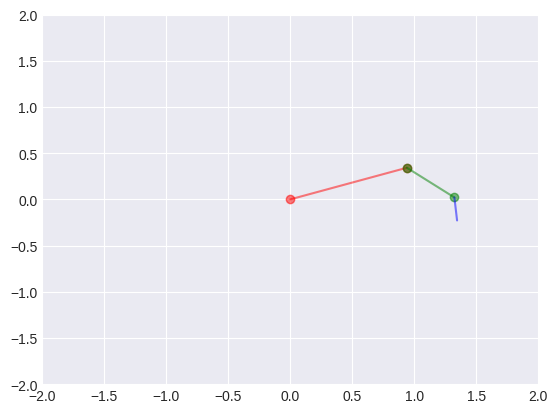

In [8]:
arm.forward_kinematics(theta1=20, theta2=-60, theta3=-45)
arm.visualize(alpha=0.5)
arm.get_eef_pose()



0it [00:00, ?it/s]

7947it [00:16, 646.37it/s]

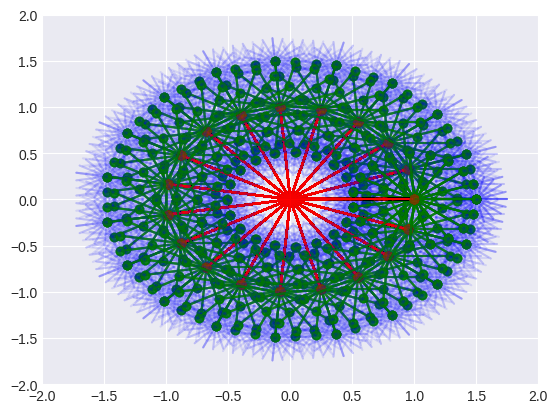

8000it [00:30, 646.37it/s]

In [49]:
from tqdm import tqdm
pbar = tqdm()

for t1 in np.linspace(0, 360, 20):
    for t2 in np.linspace(0, 360, 20):
        for t3 in np.linspace(0, 360, 20):
            arm.forward_kinematics(t1, t2, t3)
            arm.visualize(alpha=0.1)
            pbar.update(1)
            


### Example 1

array([1.3108587 , 0.43695196, 0.        ])

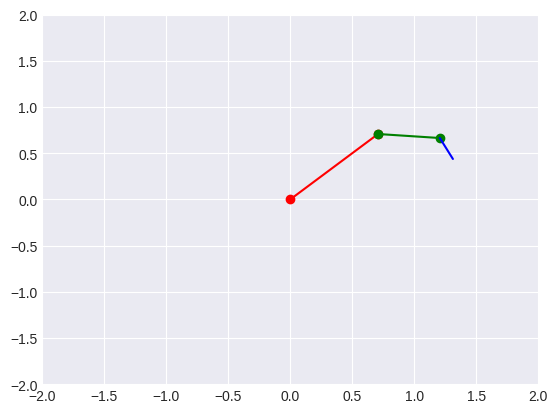

In [32]:
arm.forward_kinematics(45, -50, -60)
arm.visualize()
arm.get_eef_pose()

In [33]:
arm.inverse_kinematics(1.314, 0.4369)

0.6674776100000004 1.0


({'theta2': 48.127317229368686, 'theta1': 2.7946246372442216, 'theta3': 0.0},
 {'theta2': -48.127317229368686, 'theta1': 33.9889152308022, 'theta3': 0.0})

array([1.55637776, 0.37622774, 0.        ])

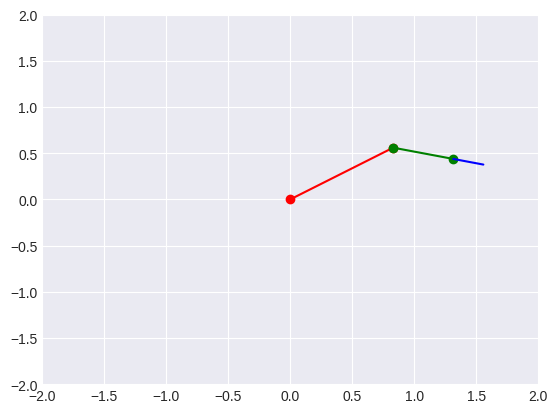

In [34]:
arm.forward_kinematics(theta1=34, theta2=-48.12, theta3=0)
arm.visualize()
arm.get_eef_pose()

array([1.47171991, 0.6307928 , 0.        ])

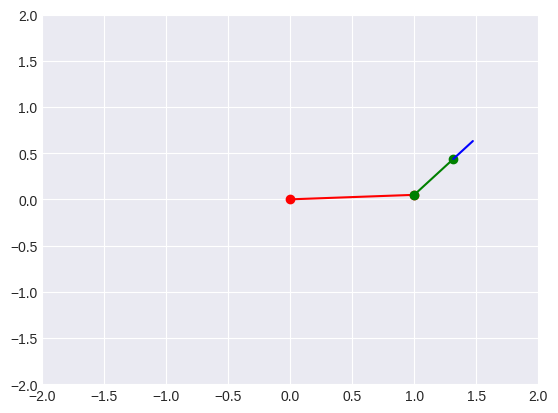

In [35]:
arm.forward_kinematics(theta1=2.79, theta2=48.12, theta3=0)
arm.visualize()
arm.get_eef_pose()

### Example 2

array([0.72330871, 0.81506105, 0.        ])

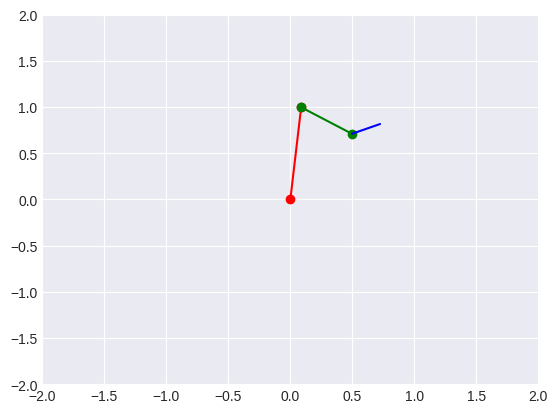

In [36]:
arm.forward_kinematics(85, -120, 60)
arm.visualize()
arm.get_eef_pose()

In [37]:
arm.inverse_kinematics(0.7233, 0.815)

-0.06261210999999989 1.0


({'theta2': 93.5897577336001, 'theta1': 21.156350521901395, 'theta3': 0.0},
 {'theta2': -93.5897577336001, 'theta1': 75.66652254909691, 'theta3': 0.0})

array([0.61888199, 1.04202777, 0.        ])

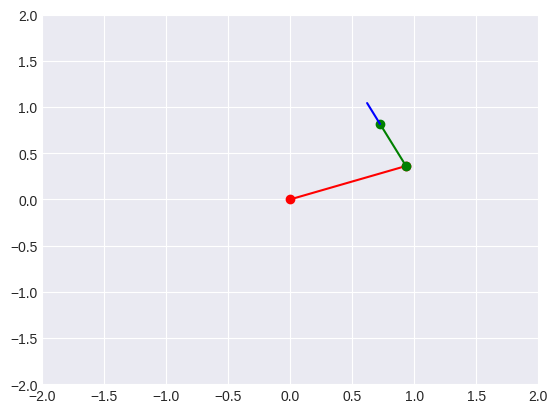

In [40]:
arm.forward_kinematics(21.15, 93.58, 0)
arm.visualize()
arm.get_eef_pose()

array([0.96129075, 0.73807648, 0.        ])

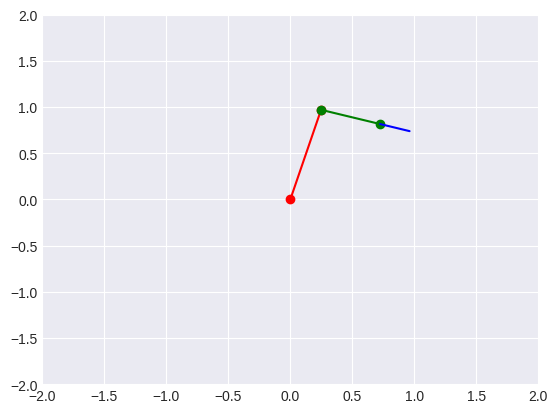

In [42]:
arm.forward_kinematics(75.66, -93.58, 0)
arm.visualize()
arm.get_eef_pose()

### Example 3

array([0.7410254 , 1.14951905, 0.        ])

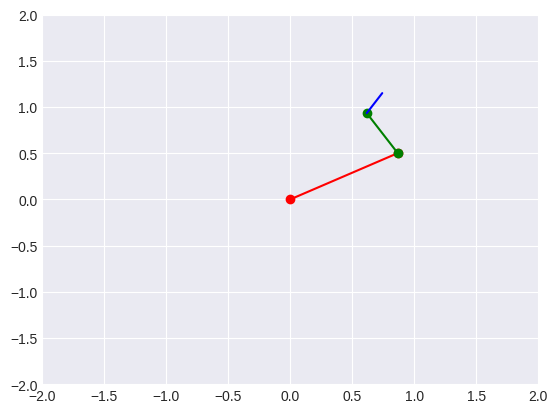

In [51]:
arm.forward_kinematics(30, 90, -60)
arm.visualize()
arm.get_eef_pose()

In [52]:
arm.inverse_kinematics(0.741, 1.1495)


0.6204312499999998 1.0


({'theta2': 51.65236652378407, 'theta1': 40.53127976747985, 'theta3': 0.0},
 {'theta2': -51.65236652378407, 'theta1': 73.85478918353408, 'theta3': 0.0})

array([0.7315104, 1.3993023, 0.       ])

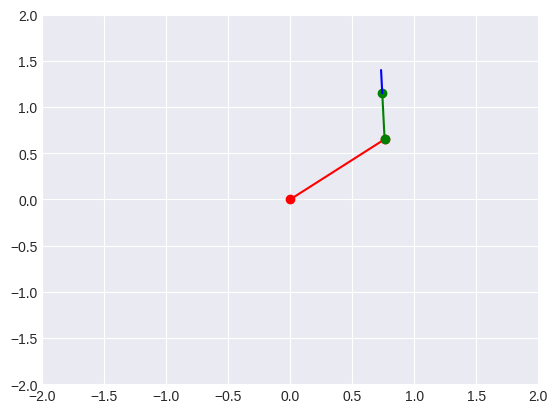

In [53]:
arm.forward_kinematics(40.53, 51.652, 0)
arm.visualize()
arm.get_eef_pose()

array([0.97256582, 1.24389314, 0.        ])

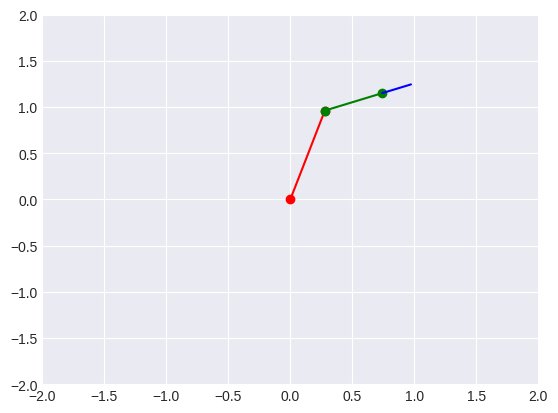

In [54]:
arm.forward_kinematics(73.85, -51.652, 0)
arm.visualize()
arm.get_eef_pose()

### Example 4

array([ 0.96650635, -0.5580127 ,  0.        ])

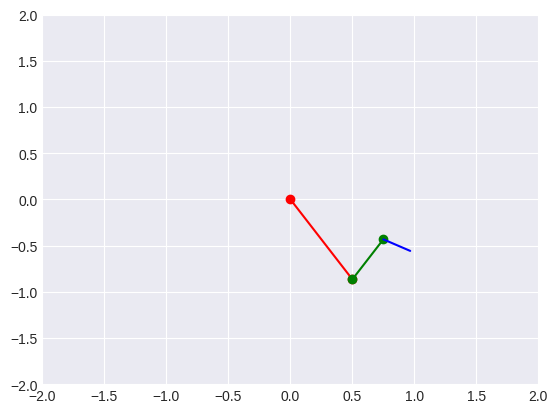

In [59]:
arm.forward_kinematics(-60, 120, -90)
arm.visualize()
arm.get_eef_pose()

In [60]:
arm.inverse_kinematics(0.9665, -0.5580)


-0.004513750000000094 1.0


({'theta2': 90.25861970296593, 'theta1': -56.61623298093342, 'theta3': 0.0},
 {'theta2': -90.25861970296593, 'theta1': -3.3829635850697204, 'theta3': 0.0})

array([ 1.17473605, -0.41946425,  0.        ])

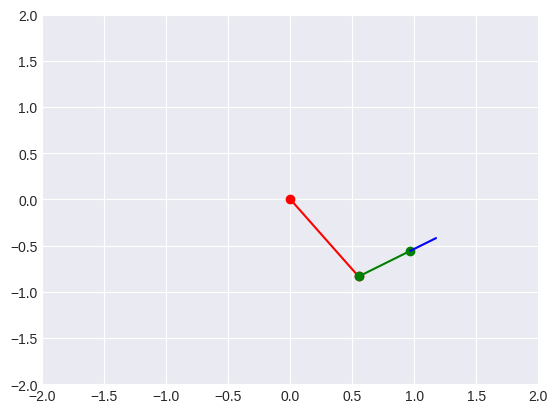

In [61]:
arm.forward_kinematics(-56.61, 90.25, 0)
arm.visualize()
arm.get_eef_pose()

array([ 0.95067115, -0.80744657,  0.        ])

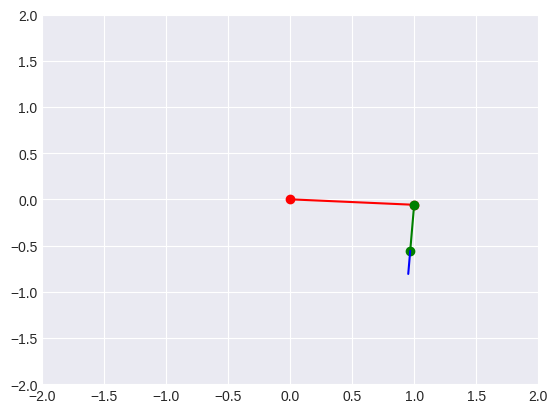

In [62]:
arm.forward_kinematics(-3.38, -90.258, 0)
arm.visualize()
arm.get_eef_pose()

## 3. Axis-angle

Given,

$$
R = (I + \sin\theta \hat{n} + (1 - \cos\theta) \hat{n}^2)
$$

We extract $\theta$ as, 
$$
\cos\theta = \frac{\text{trace}(R) - 1}{2} \\
\implies \theta = \cos^{-1}(\frac{\text{trace}(R) - 1}{2})
$$

and, the axis of rotation $\hat{n} = [n_1, n_2, n_3]^T$ as, 

$$
\hat{n} = \frac{R - R^T}{2 \sin \theta}
$$

In [63]:
def skew2vec(S):
    return np.array([S[2, 1], S[0, 2], S[1, 0]])
def vec2skew(v):
    return np.array([[0, -v[2], v[1]],
                    [v[2], 0, -v[0]],
                    [-v[1], v[0], 0]])
    
def check_same_rotation_matrix(R1, R2):
    return np.linalg.norm(R1 @ R2.T - np.eye(3)) < 1e-8

def R2rodrigues(R):
    theta = np.arccos((np.trace(R) - 1) / 2)
    n = (R - R.T)/(2 * np.sin(theta))
    n = skew2vec(n)
    return theta, n

def rodrigues2R(theta, n):
    n = n / np.linalg.norm(n)
    n = vec2skew(n)
    return np.eye(3) + np.sin(theta) * n + (1 - np.cos(theta)) * n @ n

def R2quat(R):
    q = np.zeros(4)
    q[3] = np.sqrt(1 + np.trace(R)) / 2
    q[0] = (R[2, 1] - R[1, 2]) / (4 * q[3])
    q[1] = (R[0, 2] - R[2, 0]) / (4 * q[3])
    q[2] = (R[1, 0] - R[0, 1]) / (4 * q[3])
    return q

def rotate_using_q(q, points):
    rot = Rotation.from_quat(q).as_matrix()
    return points @ rot.T

rot = euler2R([np.pi/6, np.pi/4, np.pi/3])
theta, n = R2rodrigues(rot)

print(f"Input Rotation Matrix: {rot}")
print('-' * 50)
print(f"theta: {theta:.4f}")
print(f"n: {n}")


Input Rotation Matrix: [[ 0.61237244  0.28033009  0.73919892]
 [ 0.35355339  0.73919892 -0.5732233 ]
 [-0.70710678  0.61237244  0.35355339]]
--------------------------------------------------
theta: 1.2105
n: [0.63347432 0.77277397 0.03912386]


In [64]:
rot2 = rodrigues2R(theta=theta, n=n)
check_same_rotation_matrix(rot, rot2)


True

In [65]:
q = R2quat(rot)
q

array([0.36042341, 0.43967974, 0.02226003, 0.82236317])

In [66]:
pcd = trimesh.load('./toothless.ply')
pcd.apply_scale(0.01)
pcd = np.asarray(pcd.sample(512))

pcd


array([[-2.35223493,  0.43527828, -0.62901328],
       [-0.12902866,  0.02441573, -0.55437935],
       [ 1.42389403,  0.43527828,  0.0814177 ],
       ...,
       [ 0.66496674,  0.43527828, -0.68170527],
       [ 0.41248469,  0.43527828, -0.26683845],
       [ 0.92921063,  0.42527828, -0.54853302]])

In [67]:
def visualize_pcd(pcd):
    colors = np.zeros((512, 4))
    colors[0, :] = 1.0
    point_cloud = trimesh.points.PointCloud(pcd, colors=colors)
    axis = trimesh.creation.axis(axis_length=0.5)
    scene = trimesh.Scene([point_cloud, axis])
    return scene

In [68]:
visualize_pcd(pcd @ rot.T).show()

In [69]:
visualize_pcd(pcd @ rot2.T).show()


In [70]:
visualize_pcd(rotate_using_q(q, pcd)).show()

## DH representation

In [71]:
DH_params = np.array([
    [np.pi / 2, 0, 0.0892, np.pi / 6],  
    [0, -0.425, 0, 0],                  
    [0, -0.3922, 0, np.pi / 3],                 
    [np.pi / 2, 0, 0.1093, np.pi / 4],          
    [-np.pi / 2, 0, 0.09475, np.pi / 2],        
    [0, 0, 0.0825, 0]                   
])

def DH2T(alpha, a, d, theta):
      return np.array([[np.cos(theta), -np.sin(theta) * np.cos(alpha), np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
                  [np.sin(theta), np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
                  [0, np.sin(alpha), np.cos(alpha), d],
                  [0, 0, 0, 1]])
    
# get eef pose
def get_eef_pose(DH_params):
    T = np.eye(4)
    for i, params in enumerate(DH_params):
        T = T @ DH2T(params[0], params[1], params[2], params[3])
    return T    
    
eef_pose = get_eef_pose(DH_params)
print(f"Eef Pose: {eef_pose}")


Eef Pose: [[ 5.00000000e-01 -8.36516304e-01  2.24143868e-01 -3.85486589e-01]
 [-8.66025404e-01 -4.82962913e-01  1.29409523e-01 -3.48769555e-01]
 [ 1.04530143e-16 -2.58819045e-01 -9.65925826e-01 -3.05620940e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [72]:
DH_params_home = np.array([
    [np.pi / 2, 0, 0.0892, 0],  
    [0, -0.425, 0, 0],                  
    [0, -0.3922, 0, 0],                 
    [np.pi / 2, 0, 0.1093, 0],         
    [-np.pi / 2, 0, 0.09475, 0],       
    [0, 0, 0.0825, 0]                   
])


eef_pose_home = get_eef_pose(DH_params_home)
print(f"EEF pose home: {eef_pose_home}")

EEF pose home: [[ 1.000000e+00  0.000000e+00  0.000000e+00 -8.172000e-01]
 [ 0.000000e+00  6.123234e-17 -1.000000e+00 -1.918000e-01]
 [ 0.000000e+00  1.000000e+00  6.123234e-17 -5.550000e-03]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]


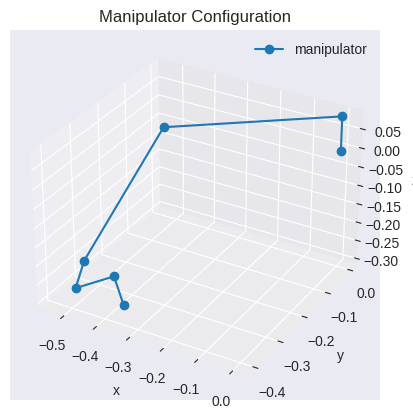

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = [0], [0], [0]
T = np.eye(4)

for param in DH_params:
    theta, d, a, alpha = param
    T = np.dot(T, DH2T(theta, d, a, alpha))
    xs.append(T[0, 3])
    ys.append(T[1, 3])
    zs.append(T[2, 3])

ax.plot(xs, ys, zs, '-o', label="manipulator")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Manipulator Configuration')

plt.legend()
plt.show()

In [72]:
import torch

# 0.97256582, 1.24389314, 0.        
l1 = 1
l2 = 0.5
l3 = 0.25

thetas = torch.randn(3)
thetas.requires_grad = True

x_true, y_true = 1.0, 1.0
optimizer = torch.optim.Adam([thetas], lr=10e-3)

for i in range(500):
    x = l1 * torch.cos(thetas[0]) + l2 * torch.cos(thetas[0] + thetas[1]) + l3 * torch.cos(thetas[0] + thetas[1] + thetas[2])
    y = l1 * torch.sin(thetas[0]) + l2 * torch.sin(thetas[0] + thetas[1]) + l3 * torch.sin(thetas[0] + thetas[1] + thetas[2])
    
    loss = ((x - x_true) ** 2) + ((y - y_true) ** 2)
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        print(f"Loss: {loss.item()}")
        print(f"thetas: {thetas.detach().numpy()}")
        print("=" * 50)
        

thetas = thetas.detach().numpy() * (180 / np.pi)
print(f"Predicted thetas: {thetas} degrees")

Loss: 8.302660942077637
thetas: [-1.429204   -0.4141165   0.49877724]
Loss: 4.422675132751465
thetas: [-0.9088183   0.14309949  1.0265335 ]
Loss: 1.3137969970703125
thetas: [-0.43627045  0.6554847   1.3931807 ]
Loss: 0.3607848286628723
thetas: [-0.1216221  0.9279041  1.4305234]
Loss: 0.1131330206990242
thetas: [0.06440308 1.025097   1.3477395 ]
Loss: 0.04483109712600708
thetas: [0.16838038 1.0367411  1.2548451 ]
Loss: 0.021665096282958984
thetas: [0.2248375 1.0140717 1.1738513]
Loss: 0.011207918636500835
thetas: [0.25665793 0.98283505 1.1074753 ]
Loss: 0.005774121731519699
thetas: [0.27664012 0.9541979  1.0551428 ]
Loss: 0.0029095481149852276
thetas: [0.2906059 0.9314079 1.0151674]
Predicted thetas: [17.227606 52.402225 56.48489 ] degrees


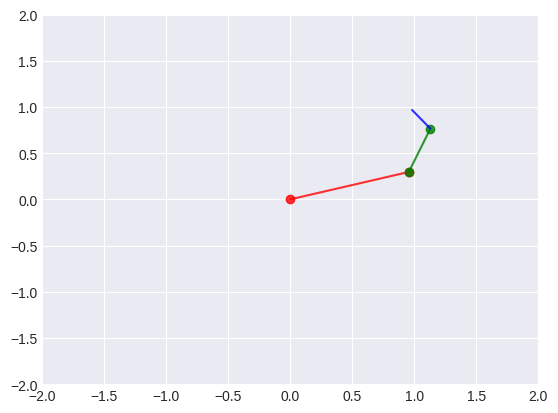

In [73]:
arm = Manipulator()
arm.forward_kinematics(*thetas)
arm.visualize(alpha=0.8)


array([0.51325835, 0.41721201, 0.        ])

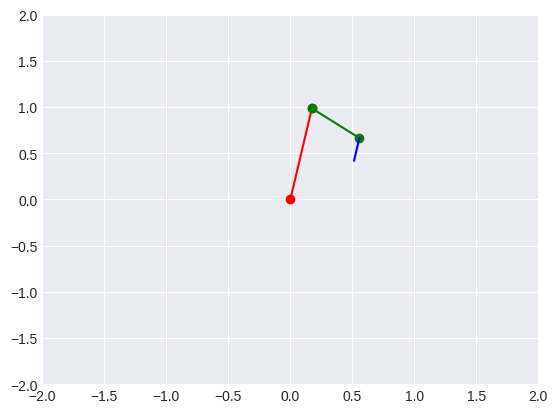

In [38]:
arm.forward_kinematics(80, -120, -60)
arm.visualize()
arm.get_eef_pose()

In [1]:
import numpy as np
from scipy.optimize import minimize

# Link lengths
l1, l2, l3 = 1, 0.5, 0.25

# Target position
x_true, y_true = 1.0, 1.0

# Define the objective function
def objective(thetas):
    # Forward kinematics
    x = l1 * np.cos(thetas[0]) + l2 * np.cos(thetas[0] + thetas[1]) + l3 * np.cos(thetas[0] + thetas[1] + thetas[2])
    y = l1 * np.sin(thetas[0]) + l2 * np.sin(thetas[0] + thetas[1]) + l3 * np.sin(thetas[0] + thetas[1] + thetas[2])
    
    # Loss: Squared distance between (x, y) and (x_true, y_true)
    loss = ((x - x_true) ** 2) + ((y - y_true) ** 2)
    return loss

# Initial guess for theta values
initial_thetas = np.random.randn(3)

# Perform optimization
result = minimize(objective, initial_thetas, method='BFGS')

# Extract optimized angles in radians and convert to degrees
optimized_thetas = result.x * (180 / np.pi)

print("Optimization Results:")
print(f"Optimal loss: {result.fun}")
print(f"Predicted thetas (degrees): {optimized_thetas}")


Optimization Results:
Optimal loss: 7.534614602698966e-12
Predicted thetas (degrees): [ 44.95880564 390.04295764 235.6880926 ]
